In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import requests
import json
from bs4 import BeautifulSoup
import geopy
from geopy.geocoders import Nominatim
from math_functions import *
from wrangling_functions import *
from plotting_functions import *
from data_extraction_functions import *

In [2]:
#!cp /content/drive/MyDrive/wrangle_zillow_data.py

# 1. Goal

What are the best locations in North Carolina (NC) to buy a home/condo? 
What are the best home/condo options in the selected areas? 

# 2. Criteria for finding best location

https://www.investopedia.com/articles/mortages-real-estate/11/factors-affecting-real-estate-market.asp

- Stable real-estate value appreciation
 - Look at historical housing market appreciation (10 years after 2008 crash)
- Look at increase in population over the past 5 years
- Look at the number of new houses in the area
- Look at number of new companies moving into an area 
- Look at the number of universities and schools in the area
- Look at the number of airports in the area
- Look at the number of restaurants, bars, coffee shops, retailers in the area

# 3. Criteria for finding the best home/condo? 

- Condo
- Price below 500k
- At least 2 bedrooms
- HOA fees below $1000/month

# 4. What determines the price of a house? 

https://www.opendoor.com/w/blog/factors-that-influence-home-value

1. Neighborhood comps
2. Location
3. Home size and usable space
4. Age and condition
5. Upgrades and updates
6. Local market
7. Economic indicators
8. Interest rates


# 5. Real estate data sources


# 8. Explore Zillow housing prices data

### 8.1 Loading dataset

In [3]:
path = r'C:\Users\sdas\Github_DS\north_carolina_best_real_estate_locations\Datasets\Zip_zhvi_bdrmcnt_2_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv'
df_zillow = pd.read_csv(path)
df_zillow.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,71959.0,...,185348.0,189190.0,192930.0,196007.0,198450.0,199265.0,199801.0,200478.0,202409.0,203667.0
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,NaN,...,349154.0,358056.0,365657.0,370044.0,370861.0,368537.0,368319.0,369042.0,371358.0,371340.0
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,71722.0,...,139025.0,141675.0,144407.0,147117.0,148500.0,149784.0,150962.0,152527.0,153612.0,154389.0
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,223073.0,...,472787.0,473026.0,473582.0,476574.0,479754.0,480962.0,481936.0,482562.0,482251.0,482909.0
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,230564.0,...,702012.0,705073.0,710696.0,716560.0,721183.0,722750.0,723304.0,727186.0,730187.0,729557.0


### 8.2 Filtering the data to keep the most relevant housing prices and variables

The Zillow data consists of monthly housing prices over time (from 1996 to 2017) for 8946 zip codes across the United States. Below, we create a subset of the main dataset to include the following housing prices: 
- **January 2012**: 2nd reference price when the average housing price was lowest after the 2008 crash
- **June 2017**: Most recently recorded housing price

These years were selected based on the timeseries analysis shown below using the following methodology: 
1. The housing price for all zip codes are averaged across dates 
2. A timeseries plot of the averaged housing prices is generated

In [4]:
df_zillow_timeseries = df_zillow.drop(['RegionID','RegionName','City','State','Metro','CountyName','SizeRank'],axis=1)
df_zillow_timeseries = df_zillow_timeseries.mean()
df_zillow_timeseries.index = pd.to_datetime(df_zillow_timeseries.index)

Text(0, 0.5, 'Average housing price ($)')

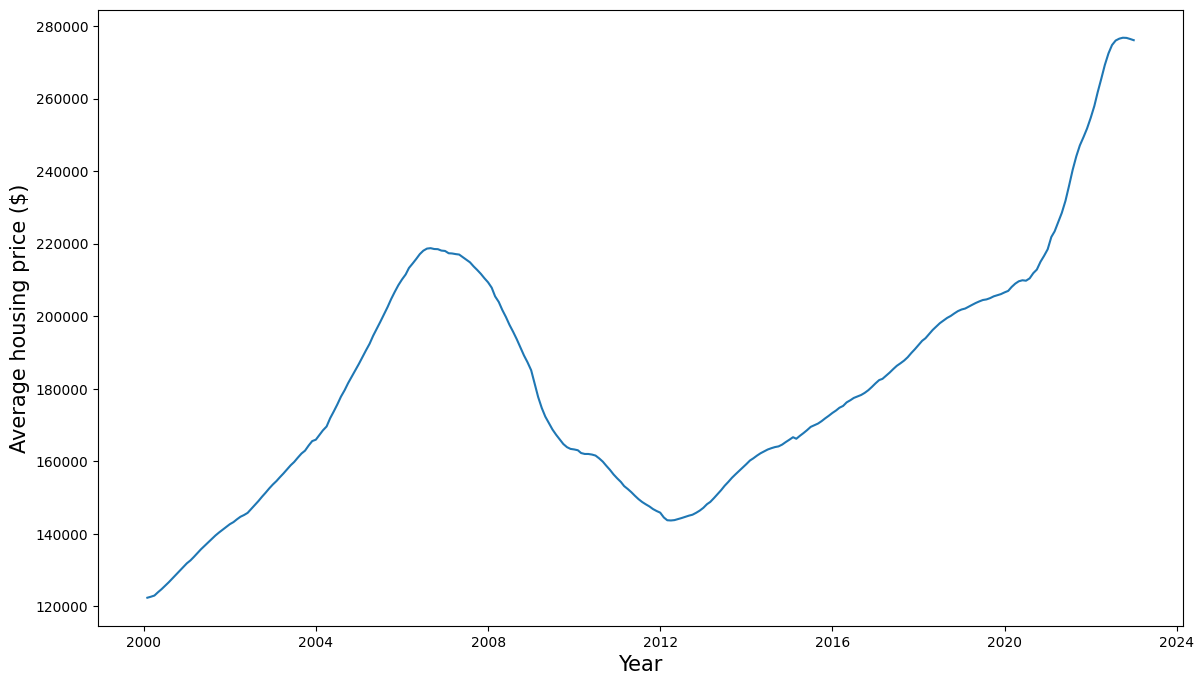

In [5]:
plt.figure(figsize=(14,8))
plt.plot(df_zillow_timeseries)
plt.xlabel('Year',size=15)
plt.ylabel('Average housing price ($)',size=15)

### 8.3 Converting dates from *string* to Pandas *datetime* format

In [6]:
df_zillow = format_dates(df_zillow)
df_zillow.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01,...,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,71959.0,...,185348.0,189190.0,192930.0,196007.0,198450.0,199265.0,199801.0,200478.0,202409.0,203667.0
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,NaN,...,349154.0,358056.0,365657.0,370044.0,370861.0,368537.0,368319.0,369042.0,371358.0,371340.0
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,71722.0,...,139025.0,141675.0,144407.0,147117.0,148500.0,149784.0,150962.0,152527.0,153612.0,154389.0
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,223073.0,...,472787.0,473026.0,473582.0,476574.0,479754.0,480962.0,481936.0,482562.0,482251.0,482909.0
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,230564.0,...,702012.0,705073.0,710696.0,716560.0,721183.0,722750.0,723304.0,727186.0,730187.0,729557.0


### 8.3 Filtering required variables

Below we are filtering the dataset by the required variables such as city, state and dates. Note that the date values need to be supplied to the *filter_variables* function in Pandas datetime format to avoid any errors. 

In [7]:
#Selecting region name, city, state, county name, start date (datetime format), end date (datetime format)
df_zillow = filter_data_timespan(df_zillow,['RegionName','City','State','CountyName'],
                                pd.to_datetime('2012-01').to_period('m'),pd.to_datetime('2017-06').to_period('m'))
df_zillow.head()

,RegionName,City,State,CountyName,2012-01,2017-06
0,77449,NaN,TX,Harris County,70886.0,118721.0
1,77494,NaN,TX,Fort Bend County,196390.0,264651.0
2,79936,El Paso,TX,El Paso County,91197.0,94119.0
3,11368,New York,NY,Queens County,322850.0,439917.0
4,11385,New York,NY,Queens County,389338.0,584976.0


### 8.4 Filtering only North Carolin RTP listings

Cities in the RTP: 
- Raleigh
- Durham
- Chapel Hill
- Morrisville
- Cary

Below, we filter the dataset to only include zip codes from New York, which actually represents the entire New York City area including the five buroughs. This was verified by individually checking whether the City variable for any of the instances contained the following buroughs: 
- Manhattan
- Brooklyn: There were three instances present but they were from states other than NY
- Bronx
- Queens
- Staten Island

In [8]:
df_zillow = df_zillow[(df_zillow['City']=='Morrisville') | (df_zillow['City']=='Durham') | (df_zillow['City']=='Raleigh') | (df_zillow['City']=='Chapel Hill') | 
                      (df_zillow['City']=='Cary') | (df_zillow['City']=='Greensboro') | (df_zillow['City']=='Winston-Salem') | (df_zillow['City']=='High Point')]
df_zillow = df_zillow[df_zillow['State']=='NC']
df_zillow.head()

,RegionName,City,State,CountyName,2012-01,2017-06
125,27610,Raleigh,NC,Wake County,96583.0,130580.0
313,27406,Greensboro,NC,Guilford County,57299.0,60741.0
482,27703,Durham,NC,Durham County,110013.0,154665.0
525,27713,Durham,NC,Durham County,121101.0,144836.0
543,27603,Raleigh,NC,Wake County,145799.0,191724.0


In [9]:
df_zillow['City'].value_counts()[:30]

Raleigh          15
Greensboro        9
Durham            7
Winston-Salem     7
Cary              4
High Point        3
Chapel Hill       3
Morrisville       1
Name: City, dtype: int64

### 8.5 Renaming columns to make them more readable

In [10]:
df_zillow = rename_cols(df_zillow,,)
df_zillow.head()

TypeError: rename_cols() missing 1 required positional argument: 'end_date'

### 8.6 Converting zipcode values to  string for easier manipulation

In [ ]:
df_zillow = convert_zip_str(df_zillow)
df_zillow.head()

## 4.1 Creating new variable to record price increase (Zillow)

In [ ]:
df_zillow = add_price_metrics(df_zillow)
df_zillow.head()

### 8.7 Data visualization

#### 8.7.1 Initial purchase price



In [ ]:
df_zillow[['County','EndPrice']].groupby('County').agg(['count','mean','median','std','sum'])['EndPrice'].sort_values('mean')

In [ ]:
df_zillow[['City','EndPrice']].groupby('City').agg(['count','mean','median','std','sum'])['EndPrice'].sort_values('mean')

**Noteable insights**
- On average, Chapel Hill (Orange county) had the highest housing prices (193,933) followed by the Wake county cities (178,533) such as Raleigh, Cary and Morrisville. 
- Chapel Hill having the highest mean housing price was surprising as I would have expected one of the Wake county cities to be top. It could have to do with the presence of UNC Chapel Hill. This also indicates that prior to 2017, real estate prices in Chapel Hill probably appreciated at a greater rate than the other counties on this list. 
- Following the top two counties, we see a significant drop in purhcase price for Durham with 128,457. This is not surprising as Durham was not too developed and was crime-ridden historically. I do expect this trend to change a little as the city is well developed now and continues to attract new residents, companies and students especially due to the presence of Duke University. 
- Next, we have the cities from Guilford county (Greensboro and High Point) and Forsyth county (Winston-Salem) with mean prices of 83,873 and 76,887. We see a significant drop in housing prices between the Research Triangle Park (RTP) cities and Piedmont Triad cities. This is not surprising as the RTP area is more developed especially in these areas:
-- Big universities
-- Greater population and density
-- More tech companies
-- Bigger airports


#### 8.7.2 Price increase percent (appreciation%)

In [ ]:
uni_scatterplot(df_zillow,'PriceIncreasePerc','Housing price increase per year (%)')

In [ ]:
df_zillow[['County','PriceIncreasePerc']].groupby('County').agg(['count','mean','median','std','sum'])['PriceIncreasePerc'].sort_values('mean')

In [ ]:
df_zillow[['City','PriceIncreasePerc']].groupby('City').agg(['count','mean','median','std','sum'])['PriceIncreasePerc'].sort_values('mean')

#### **Noteable insights**: 
- When looking at housing price percentage increase, this metric posts a slightly different picture to the initial purchase price
- One thing that is immediately apparent is that **Chapel Hill** drops down in the list with a **18.66%** increase over the five year period. 
- Wake county cities such as **Cary, Morrisville and Raleigh** have the highest rate of price increase with **32.46%, 31.49% and 27.02%** respectively, followed by **Durham at 21.81%**. Based on this data, Durham is a more lucrative place to purchase a house than Chapel Hill in the longer term. 
- Despite Chapel Hill having a higher mean housing price, counties in Durham and Wake could overtake Chapel Hill in the long term due to greater price appreciation. 
- Note that all zipcodes in Cary and Morrisville observe >30% increase whereas the values for the zipcodes in Raleigh have a greater spread. This is reflected in the standard deviation numbers. Based on this observation, there is a higher chance of making a >30% return when buying property in Cary/Morrisville as compared to Raleigh. 
- The highest value is observed for zipcode 27608 in Raleigh. However, Raleigh does have other zipcodes such as 27614 which sees lower values than some Chapel Hill or Durham zipcodes, albeit having a increase of >20%. 
- Once again, the cities in the Triad are significantly behind with **High Point, Greensboro and Winston-Salem seeing 11.8%, 10.28% and a measly 2.77%** respectively. Most Greensboro/High Point zipcodes saw an appreciation between 10-20% whereas Winston-Salem saw close to 0% increase or even depreciation. 
- Based on these observations alone, it is clear that the long term return on investment would certainly be higher in the RTP area. 

#### 8.7.3 Price increase

In [ ]:
uni_scatterplot(df_zillow,'PriceIncrease','Housing price increase ($)')

In [ ]:
df_zillow[['County','PriceIncrease']].groupby('County').agg(['count','mean','median','std','sum'])['PriceIncrease'].sort_values('mean')

In [ ]:
df_zillow[['City','PriceIncrease']].groupby('City').agg(['count','mean','median','std','sum'])['PriceIncrease'].sort_values('mean')

#### **Noteable insights**: 
- Despite being a decent indicator of housing price appreciation, the absolute price increase is not as important as the price increase percentage as the former does not take the initial price into account which is crucial. For example, a house with a higher price would probably appreciate by a higher value than one with a lower purchase price despite the appreciation percentages being the same. 
- As expected, we see that **Wake, Orange and Durham counties saw 39,466, 30,000 and 23,314 increases** respectively. 
- In stark comparison, **Guilford and Forsyth counties saw appreciation of 8,513 and 3325 respectively**. 

#### 8.7.4 Calculating *return on investment* and rate of return (ROI)

In [ ]:
df_zillow_10yr = return_on_investment(df_zillow, 10)
df_zillow_10yr.head()

#### 8.7.5 Return on investment 

- Calculated by multiplying the average yearly price increase (from 2012 to 2017) by the number of years 

In [ ]:
uni_scatterplot(df_zillow_10yr,'ReturnOnInvestment','Return on investment ($)')

In [ ]:
df_zillow_10yr[['County','ReturnOnInvestment']].groupby('County').agg(['count','mean','median','std','sum'])['ReturnOnInvestment'].sort_values('mean')

In [ ]:
df_zillow_10yr[['City','ReturnOnInvestment']].groupby('City').agg(['count','mean','median','std','sum'])['ReturnOnInvestment'].sort_values('mean')

#### **Noteable insights**
- There are two main variables that affect return on investment
 - *Initial purchase price*
 - *Price increase percentage*
- As expected, the return on investment over 10 years is highly correlated with the price increase data from 2012 to 2017 since the yearly increases are the same. 
- We will see further proof of this below. 

#### 8.7.6 Return on investment v/s price increase percent

In [ ]:
bi_scatterplot(df_zillow_10yr,'PriceIncreasePerc','ReturnOnInvestment','Housing price increase (%)','Return on investment ($)')

#### **Noteable insights**
- There is a high correlation between return on investment and price increase percentage. This is expected since the future home value is calculated based on the price increase percentage. 
- We see two Raleigh zipcodes 27601 and 27608 which deviate slightly from the general trend. Zipcode 27601 has a high return on investment mostly due to it's high initial purchase price while 27608 has the highest price increase percentage.  

In [ ]:
uni_scatterplot(df_zillow_10yr,'RateOfReturn','Rate of return (%)')

In [ ]:
df_zillow_10yr[['County','RateOfReturn']].groupby('County').agg(['count','mean','median','std','sum'])['RateOfReturn'].sort_values('mean')

In [ ]:
df_zillow_10yr[['City','RateOfReturn']].groupby('City').agg(['count','mean','median','std','sum'])['RateOfReturn'].sort_values('mean')

In [ ]:
bi_scatterplot(df_zillow_10yr,'PriceIncreasePerc','RateOfReturn','Housing price increase (%)','Rate of return (%)')

In [ ]:
bi_scatterplot(df_zillow_10yr,'EndPrice','RateOfReturn','Initial purchase price ($)','Rate of return (%)')

### 9. Major NC cities, 10-year span

In [2]:
path = r'C:\Users\sdas\Github_DS\north_carolina_best_real_estate_locations\Datasets\Zip_zhvi_bdrmcnt_2_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv'
df_zillow = pd.read_csv(path)
df_zillow.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,71959.0,...,185348.0,189190.0,192930.0,196007.0,198450.0,199265.0,199801.0,200478.0,202409.0,203667.0
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,NaN,...,349154.0,358056.0,365657.0,370044.0,370861.0,368537.0,368319.0,369042.0,371358.0,371340.0
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,71722.0,...,139025.0,141675.0,144407.0,147117.0,148500.0,149784.0,150962.0,152527.0,153612.0,154389.0
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,223073.0,...,472787.0,473026.0,473582.0,476574.0,479754.0,480962.0,481936.0,482562.0,482251.0,482909.0
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,230564.0,...,702012.0,705073.0,710696.0,716560.0,721183.0,722750.0,723304.0,727186.0,730187.0,729557.0


In [3]:
df_zillow = filter_data_pipeline(df_zillow,city_col_name="City",state_col_name="State",
                cols=['RegionName','City','State','CountyName','SizeRank'],
                start_date='2012-01',end_date='2022-12',
                cities=['Raleigh','Durham','Chapel Hill','Cary','Morrisville','Winston-Salem','Greensboro','High Point'],
                states=['NC'])
df_zillow.head()

,ZipCode,City,State,County,SizeRank,StartPrice,EndPrice
125,27610,Raleigh,NC,Wake County,128,96583.0,259197.0
313,27406,Greensboro,NC,Guilford County,316,57299.0,131110.0
482,27703,Durham,NC,Durham County,488,110013.0,317972.0
525,27713,Durham,NC,Durham County,532,121101.0,294757.0
543,27603,Raleigh,NC,Wake County,550,145799.0,329106.0


In [4]:
df_zillow = add_price_metrics(df_zillow,10)
df_zillow.head()

,ZipCode,City,State,County,SizeRank,StartPrice,EndPrice,PriceIncrease,PriceIncreasePerc,PriceIncreaseYearly
125,27610,Raleigh,NC,Wake County,128,96583.0,259197.0,162614.0,168.367104,16261.4
313,27406,Greensboro,NC,Guilford County,316,57299.0,131110.0,73811.0,128.817257,7381.1
482,27703,Durham,NC,Durham County,488,110013.0,317972.0,207959.0,189.031296,20795.9
525,27713,Durham,NC,Durham County,532,121101.0,294757.0,173656.0,143.397660,17365.6
543,27603,Raleigh,NC,Wake County,550,145799.0,329106.0,183307.0,125.725828,18330.7


In [5]:
agg_by_city(df_zillow,'EndPrice')

                    mean    median       std       max       min        sum  \
City                                                                          
Cary           349619.75  307753.0  96007.75  492836.0  290137.0  1398479.0   
Raleigh        343783.13  316368.0  92724.78  542095.0  259197.0  5156747.0   
Chapel Hill    340405.67  335370.0  51372.94  394111.0  291736.0  1021217.0   
Morrisville    338223.00  338223.0       NaN  338223.0  338223.0   338223.0   
Durham         308674.71  308864.0  22742.48  346553.0  274643.0  2160723.0   
Greensboro     164971.89  150811.0  31213.12  210642.0  131110.0  1484747.0   
Winston-Salem  149077.00  160008.0  41625.34  211199.0   95697.0  1043539.0   
High Point     128093.33  119197.0  38672.72  170439.0   94644.0   384280.0   

               count  
City                  
Cary               4  
Raleigh           15  
Chapel Hill        3  
Morrisville        1  
Durham             7  
Greensboro         9  
Winston-Salem      7  
Hi

In [6]:
agg_by_county(df_zillow,'EndPrice')

                      mean    median       std       max       min        sum  \
County                                                                          
Wake County      344672.45  315555.5  88309.93  542095.0  259197.0  6893449.0   
Orange County    340405.67  335370.0  51372.94  394111.0  291736.0  1021217.0   
Durham County    308674.71  308864.0  22742.48  346553.0  274643.0  2160723.0   
Guilford County  155752.25  148269.0  35477.64  210642.0   94644.0  1869027.0   
Forsyth County   149077.00  160008.0  41625.34  211199.0   95697.0  1043539.0   

                 count  
County                  
Wake County         20  
Orange County        3  
Durham County        7  
Guilford County     12  
Forsyth County       7  


In [7]:
agg_by_city(df_zillow,'PriceIncreasePerc')

                 mean  median    std     max     min      sum  count
City                                                                
Durham         180.65  159.81  45.22  273.09  143.40  1264.57      7
Morrisville    145.59  145.59    NaN  145.59  145.59   145.59      1
High Point     145.05  133.19  55.54  205.55   96.39   435.14      3
Cary           143.58  147.74  10.77  151.65  131.34   430.73      3
Raleigh        135.57  136.05  16.19  168.37  107.21  2033.58     15
Greensboro     115.12  105.05  20.77  153.46   98.34  1036.07      9
Winston-Salem  106.85  108.53  22.98  142.76   73.95   641.09      6
Chapel Hill     90.27   90.23   1.41   91.71   88.88   270.81      3


In [8]:
agg_by_county(df_zillow,'PriceIncreasePerc')

                   mean  median    std     max     min      sum  count
County                                                                
Durham County    180.65  159.81  45.22  273.09  143.40  1264.57      7
Wake County      137.36  139.81  15.15  168.37  107.21  2609.90     19
Guilford County  122.60  107.73  32.52  205.55   96.39  1471.20     12
Forsyth County   106.85  108.53  22.98  142.76   73.95   641.09      6
Orange County     90.27   90.23   1.41   91.71   88.88   270.81      3


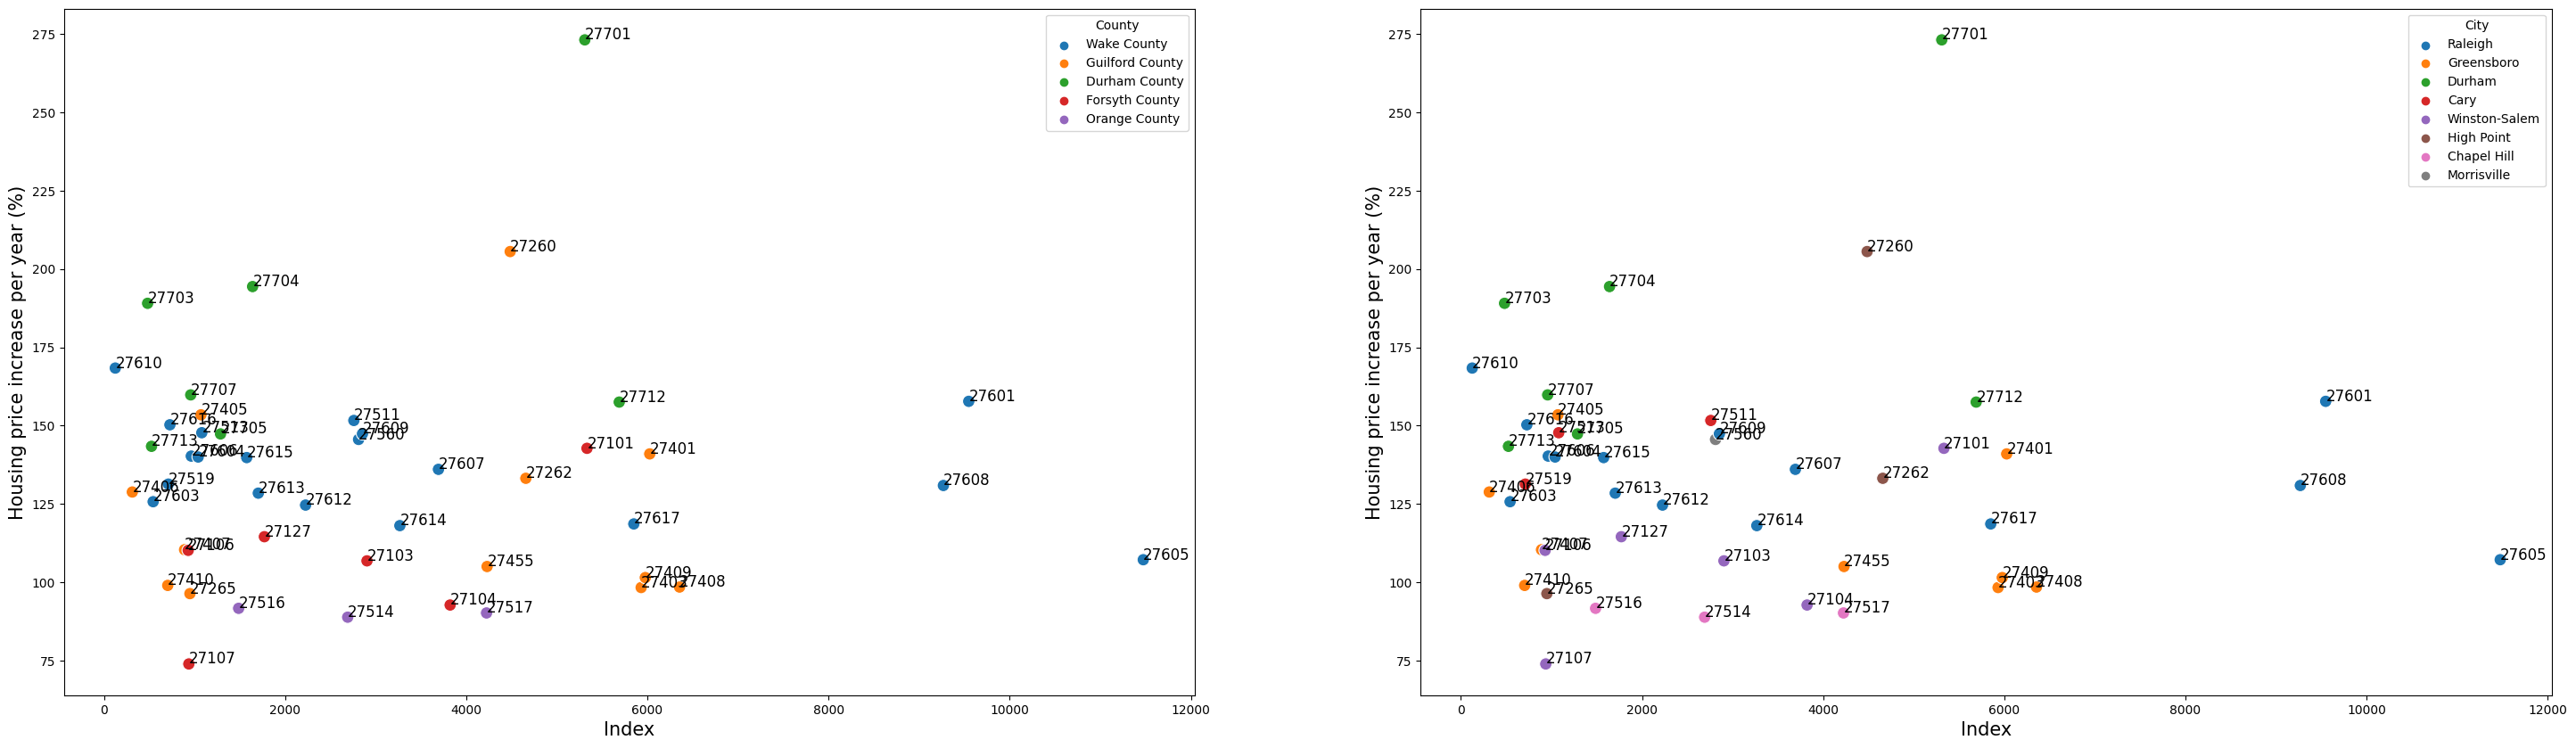

In [9]:
uni_scatterplot(df_zillow,'PriceIncreasePerc','Housing price increase per year (%)')

In [12]:
df_zillow_10yr_roi = return_on_investment(df_zillow, 10)

               count           mean    median           std        sum
City                                                                  
High Point         3   71801.666667   68082.0  10498.904530   215405.0
Winston-Salem      6   81387.833333   85065.5  21749.279964   488327.0
Greensboro         9   86925.000000   83888.0  12700.909426   782325.0
Chapel Hill        3  161626.333333  159071.0  25720.379494   484879.0
Raleigh           15  196892.800000  175656.0  53829.370098  2953392.0
Durham             7  197088.142857  183995.0  27312.831682  1379617.0
Morrisville        1  200505.000000  200505.0           NaN   200505.0
Cary               3  216248.666667  187696.0  55135.827556   648746.0
                 count           mean    median           std        sum
County                                                                  
Forsyth County       6   81387.833333   85065.5  21749.279964   488327.0
Guilford County     12   83144.166667   82611.0  13569.913310   997730.

In [13]:
df_zillow_10yr_ror = rate_of_return(df_zillow, 10)

               count       mean     median       std         sum
City                                                            
Chapel Hill        3  47.441306  47.431494  0.390404  142.323917
Winston-Salem      6  51.153300  52.042626  5.464395  306.919801
Greensboro         9  53.153127  51.230504  4.210732  478.378139
Raleigh           15  57.364306  57.636560  2.906420  860.464586
High Point         3  57.823597  57.117209  9.115852  173.470792
Cary               3  58.890295  59.634686  1.858992  176.670885
Morrisville        1  59.281894  59.281894       NaN   59.281894
Durham             7  63.684555  61.510116  4.994412  445.791885
                 count       mean     median       std          sum
County                                                             
Orange County        3  47.441306  47.431494  0.390404   142.323917
Forsyth County       6  51.153300  52.042626  5.464395   306.919801
Guilford County     12  54.320744  51.851787  5.697843   651.848931
Wake Count

### 10. Major California cities

In [14]:
path = r'C:\Users\sdas\Github_DS\north_carolina_best_real_estate_locations\Datasets\Zip_zhvi_bdrmcnt_2_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv'
df_zillow = pd.read_csv(path)
df_zillow.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,71959.0,...,185348.0,189190.0,192930.0,196007.0,198450.0,199265.0,199801.0,200478.0,202409.0,203667.0
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,NaN,...,349154.0,358056.0,365657.0,370044.0,370861.0,368537.0,368319.0,369042.0,371358.0,371340.0
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,71722.0,...,139025.0,141675.0,144407.0,147117.0,148500.0,149784.0,150962.0,152527.0,153612.0,154389.0
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,223073.0,...,472787.0,473026.0,473582.0,476574.0,479754.0,480962.0,481936.0,482562.0,482251.0,482909.0
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,230564.0,...,702012.0,705073.0,710696.0,716560.0,721183.0,722750.0,723304.0,727186.0,730187.0,729557.0


In [15]:
df_zillow = filter_data_pipeline(df_zillow,city_col_name="City",state_col_name="State",
                cols=['RegionName','City','State','CountyName','SizeRank'],
                start_date='2012-01',end_date='2022-12',
                cities=['Los Angeles','San Diego','San Jose','San Francisco','Fresno','Sacramento','Long Beach',
                       'Oakland','Bakersfield','Anaheim'],
                states=['CA'])
df_zillow.head()

,ZipCode,City,State,County,SizeRank,StartPrice,EndPrice
5,90011,Los Angeles,CA,Los Angeles County,5,180413.0,542335.0
8,91331,Los Angeles,CA,Los Angeles County,8,210158.0,604839.0
20,90044,Los Angeles,CA,Los Angeles County,20,198080.0,576652.0
21,90805,Long Beach,CA,Los Angeles County,21,228766.0,600305.0
23,93307,Bakersfield,CA,Kern County,23,52367.0,199827.0


In [16]:
df_zillow = add_price_metrics(df_zillow,10)
df_zillow.head()

,ZipCode,City,State,County,SizeRank,StartPrice,EndPrice,PriceIncrease,PriceIncreasePerc,PriceIncreaseYearly
5,90011,Los Angeles,CA,Los Angeles County,5,180413.0,542335.0,361922.0,200.607495,36192.2
8,91331,Los Angeles,CA,Los Angeles County,8,210158.0,604839.0,394681.0,187.802035,39468.1
20,90044,Los Angeles,CA,Los Angeles County,20,198080.0,576652.0,378572.0,191.120759,37857.2
21,90805,Long Beach,CA,Los Angeles County,21,228766.0,600305.0,371539.0,162.410061,37153.9
23,93307,Bakersfield,CA,Kern County,23,52367.0,199827.0,147460.0,281.589551,14746.0


In [17]:
agg_by_city(df_zillow,'EndPrice')

                     mean     median        std        max       min  \
City                                                                   
San Francisco  1380244.92  1443699.0  212950.50  1804178.0  933074.0   
San Jose        865539.08   877190.5  179657.64  1375138.0  598557.0   
Los Angeles     853836.09   765373.0  305279.89  2017945.0  437313.0   
Oakland         852820.83   763867.5  295409.70  1523877.0  536064.0   
San Diego       742423.42   687792.0  238671.72  1533904.0  413931.0   
Long Beach      684839.91   657980.0  131676.53   976201.0  539307.0   
Anaheim         612224.71   612872.0   51376.79   669035.0  538223.0   
Sacramento      439500.90   433832.5  114703.72   650057.0  274207.0   
Bakersfield     281930.22   249453.0   81083.19   413919.0  199827.0   
Fresno          272076.44   255343.0   81013.45   521631.0  178650.0   

                      sum  count  
City                              
San Francisco  34506123.0     25  
San Jose       22504016.0     

In [18]:
agg_by_county(df_zillow,'EndPrice')

                            mean     median        std        max       min  \
County                                                                        
San Francisco County  1380244.92  1443699.0  212950.50  1804178.0  933074.0   
Santa Clara County     865539.08   877190.5  179657.64  1375138.0  598557.0   
Alameda County         852820.83   763867.5  295409.70  1523877.0  536064.0   
Los Angeles County     836462.65   761321.0  296343.27  2017945.0  437313.0   
San Diego County       742423.42   687792.0  238671.72  1533904.0  413931.0   
Orange County          612224.71   612872.0   51376.79   669035.0  538223.0   
Sacramento County      439500.90   433832.5  114703.72   650057.0  274207.0   
Kern County            281930.22   249453.0   81083.19   413919.0  199827.0   
Fresno County          272076.44   255343.0   81013.45   521631.0  178650.0   

                             sum  count  
County                                   
San Francisco County  34506123.0     25  
Sant

In [19]:
agg_by_city(df_zillow,'PriceIncreasePerc')

                 mean  median    std     max     min       sum  count
City                                                                 
Sacramento     238.31  263.53  82.61  368.71  113.57   4766.26     20
Fresno         234.28  227.70  64.46  387.15  134.94   3982.69     17
Oakland        199.42  198.97  49.00  279.53  126.41   2393.00     12
Bakersfield    199.10  181.85  58.82  281.59  124.12   1791.88      9
San Jose       174.17  174.40  31.00  234.76  118.28   4354.13     25
San Diego      163.19  157.08  37.49  261.50   83.48   5385.22     33
Los Angeles    145.14  142.76  38.88  222.69   65.80  13642.89     94
Anaheim        138.09  140.56   9.33  145.65  120.60    966.64      7
Long Beach     131.25  127.78  27.87  175.83   83.29   1443.79     11
San Francisco   92.32   92.64  32.59  145.06   42.34   2215.59     24


In [20]:
agg_by_county(df_zillow,'PriceIncreasePerc')

                        mean  median    std     max     min       sum  count
County                                                                      
Sacramento County     238.31  263.53  82.61  368.71  113.57   4766.26     20
Fresno County         234.28  227.70  64.46  387.15  134.94   3982.69     17
Alameda County        199.42  198.97  49.00  279.53  126.41   2393.00     12
Kern County           199.10  181.85  58.82  281.59  124.12   1791.88      9
Santa Clara County    174.17  174.40  31.00  234.76  118.28   4354.13     25
San Diego County      163.19  157.08  37.49  261.50   83.48   5385.22     33
Los Angeles County    143.68  140.98  38.01  222.69   65.80  15086.68    105
Orange County         138.09  140.56   9.33  145.65  120.60    966.64      7
San Francisco County   92.32   92.64  32.59  145.06   42.34   2215.59     24


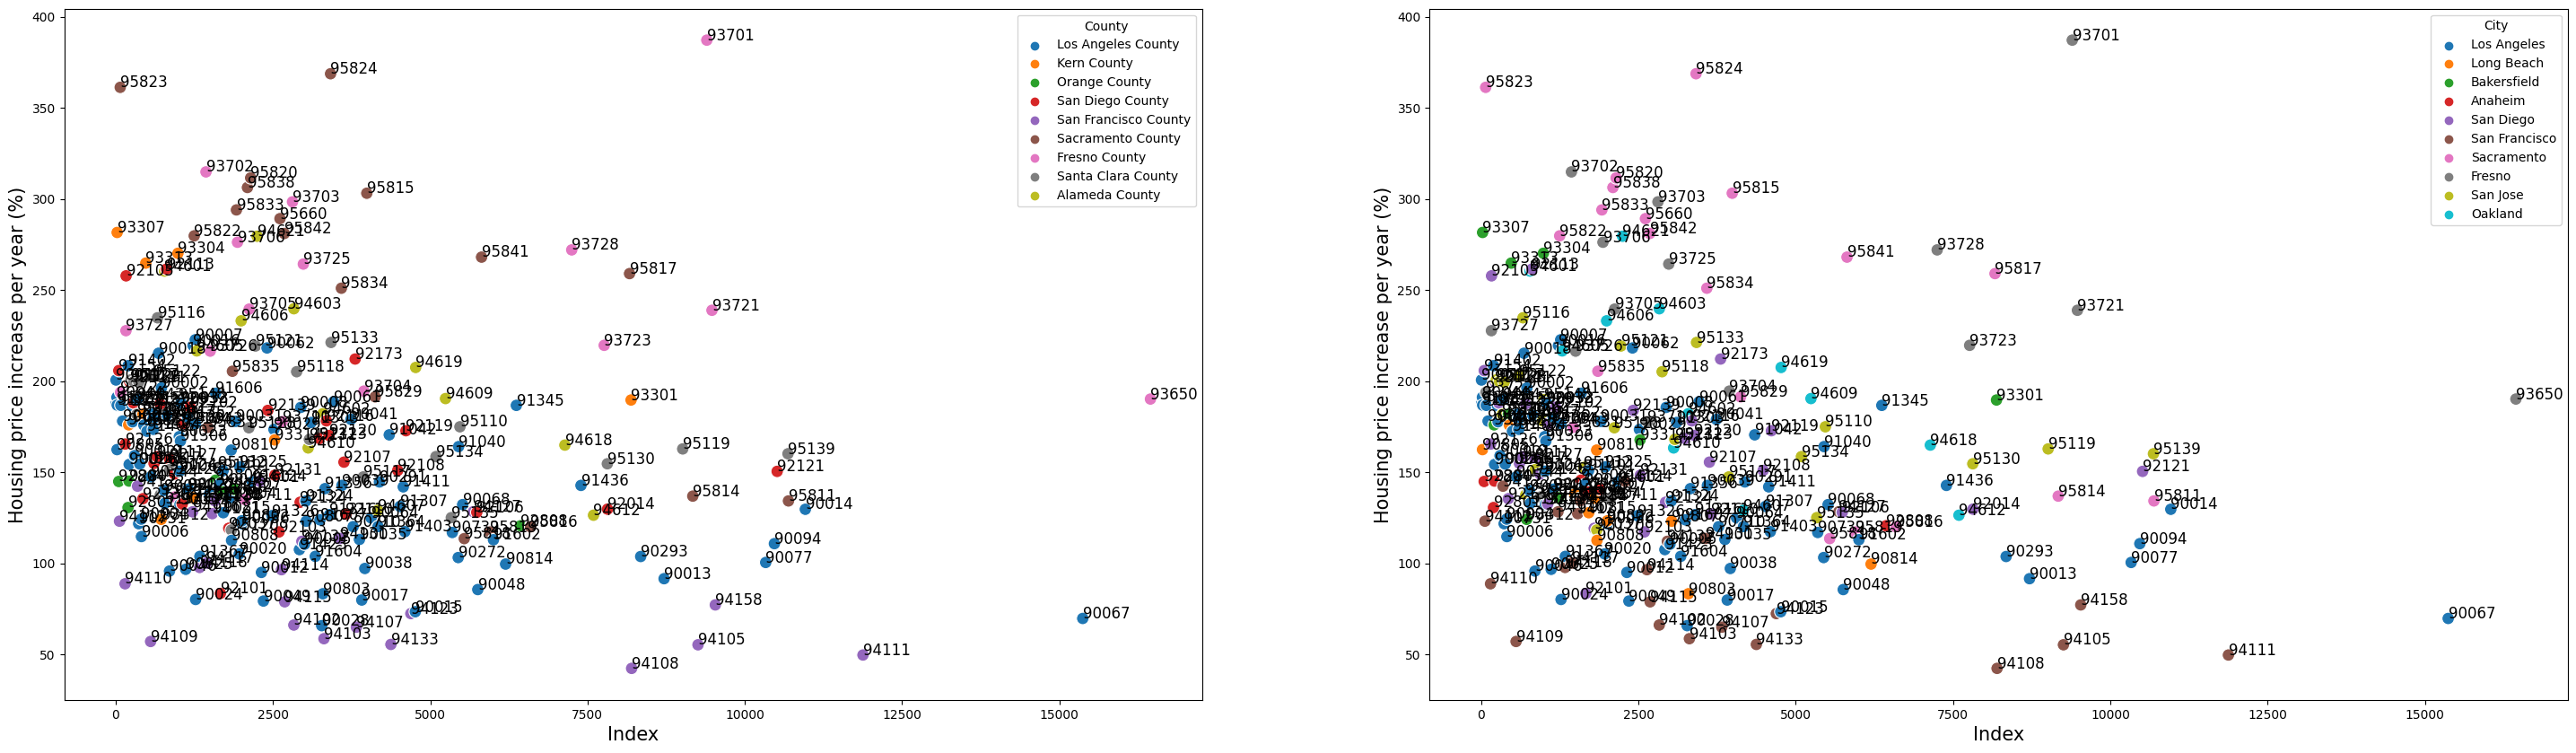

In [21]:
uni_scatterplot(df_zillow,'PriceIncreasePerc','Housing price increase per year (%)')

In [22]:
df_zillow_10yr_roi = return_on_investment(df_zillow, 10)

               count           mean    median            std         sum
City                                                                    
Bakersfield        9  180884.222222  170824.0   39216.729003   1627958.0
Fresno            17  181084.764706  172576.0   50155.561797   3078441.0
Sacramento        20  292385.100000  307905.5   43832.327810   5847702.0
Anaheim            7  354512.857143  356613.0   28811.659043   2481590.0
Long Beach        11  379374.090909  371539.0   44356.457628   4173115.0
San Diego         33  447463.424242  413255.0  121328.606525  14766293.0
Los Angeles       94  490196.180851  434632.0  162579.928046  46078441.0
San Jose          25  539871.240000  554556.0   98591.179798  13496781.0
Oakland           12  554735.416667  487700.5  179039.753988   6656825.0
San Francisco     24  637468.375000  627015.0  152662.284090  15299241.0
                      count           mean    median            std  \
County                                               

In [23]:
df_zillow_10yr_ror = rate_of_return(df_zillow, 10)

               count       mean     median       std          sum
City                                                             
San Francisco     24  46.534243  48.068111  9.119443  1116.821826
Long Beach        11  56.168215  56.097790  5.424931   617.850369
Anaheim            7  57.941778  58.429804  1.714824   405.592443
Los Angeles       94  58.129467  58.806381  6.966567  5464.169890
San Diego         33  61.280383  61.102164  5.371287  2022.252631
San Jose          25  63.070815  63.556742  4.220770  1576.770372
Bakersfield        9  65.420636  64.520570  6.627760   588.785721
Oakland           12  65.741804  66.524052  5.802750   788.901652
Sacramento        20  68.470475  72.487727  8.659112  1369.409498
Fresno            17  69.039644  69.484037  5.930170  1173.673948
                      count       mean     median       std          sum
County                                                                  
San Francisco County     24  46.534243  48.068111  9.119443  1

### 11. Major Texas cities

In [24]:
path = r'C:\Users\sdas\Github_DS\north_carolina_best_real_estate_locations\Datasets\Zip_zhvi_bdrmcnt_2_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv'
df_zillow = pd.read_csv(path)
df_zillow.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,71959.0,...,185348.0,189190.0,192930.0,196007.0,198450.0,199265.0,199801.0,200478.0,202409.0,203667.0
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,NaN,...,349154.0,358056.0,365657.0,370044.0,370861.0,368537.0,368319.0,369042.0,371358.0,371340.0
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,71722.0,...,139025.0,141675.0,144407.0,147117.0,148500.0,149784.0,150962.0,152527.0,153612.0,154389.0
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,223073.0,...,472787.0,473026.0,473582.0,476574.0,479754.0,480962.0,481936.0,482562.0,482251.0,482909.0
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,230564.0,...,702012.0,705073.0,710696.0,716560.0,721183.0,722750.0,723304.0,727186.0,730187.0,729557.0


In [25]:
df_zillow = filter_data_pipeline(df_zillow,city_col_name="City",state_col_name="State",
                cols=['RegionName','City','State','CountyName','SizeRank'],
                start_date='2012-01',end_date='2022-12',
                cities=['Houston','San Antonio','Dallas','Austin','Fort Worth','El Paso','Arlington',
                       'Corpus Christi','Plano','Irving'],
                states=['TX'])
df_zillow.head()

,ZipCode,City,State,County,SizeRank,StartPrice,EndPrice
2,79936,El Paso,TX,El Paso County,2,91197.0,154389.0
7,77084,Houston,TX,Harris County,7,71708.0,191261.0
57,75217,Dallas,TX,Dallas County,57,53890.0,190988.0
98,79938,El Paso,TX,El Paso County,99,96014.0,152650.0
100,79912,El Paso,TX,El Paso County,101,118257.0,198034.0


In [26]:
df_zillow = add_price_metrics(df_zillow,10)
df_zillow.head()

,ZipCode,City,State,County,SizeRank,StartPrice,EndPrice,PriceIncrease,PriceIncreasePerc,PriceIncreaseYearly
2,79936,El Paso,TX,El Paso County,2,91197.0,154389.0,63192.0,69.291753,6319.2
7,77084,Houston,TX,Harris County,7,71708.0,191261.0,119553.0,166.721984,11955.3
57,75217,Dallas,TX,Dallas County,57,53890.0,190988.0,137098.0,254.403414,13709.8
98,79938,El Paso,TX,El Paso County,99,96014.0,152650.0,56636.0,58.987231,5663.6
100,79912,El Paso,TX,El Paso County,101,118257.0,198034.0,79777.0,67.460700,7977.7


In [27]:
agg_by_city(df_zillow,'EndPrice')

                     mean    median        std        max       min  \
City                                                                  
Austin          542862.32  458281.0  197045.48  1142931.0  349326.0   
Plano           340917.00  353775.0   54681.82   402019.0  272877.0   
Dallas          300622.45  257514.5  147146.42   956345.0  165278.0   
Irving          285906.83  248289.0   71412.55   420782.0  242465.0   
Arlington       234402.92  229416.0   60954.60   403345.0  154322.0   
Fort Worth      233586.08  219792.5   52561.29   371360.0  173786.0   
San Antonio     216138.70  195641.5   83917.73   645338.0  124360.0   
Houston         213123.97  180652.0   95029.25   672731.0  108050.0   
Corpus Christi  156333.71  154824.5   57090.18   298636.0   79607.0   
El Paso         152230.87  145531.0   20592.74   198034.0  127119.0   

                       sum  count  
City                               
Austin          18457319.0     34  
Plano            2045502.0      6  
Dal

In [28]:
agg_by_county(df_zillow,'EndPrice')

                        mean    median        std        max       min  \
County                                                                   
Hays County        639620.00  639620.0        NaN   639620.0  639620.0   
Travis County      547054.45  464182.0  203685.67  1142931.0  349326.0   
Williamson County  429505.50  429505.5   32349.43   452380.0  406631.0   
Collin County      331064.12  323381.0   50012.83   402019.0  272877.0   
Dallas County      298575.64  249243.5  142307.75   956345.0  165278.0   
Tarrant County     233844.03  221538.0   54510.80   403345.0  154322.0   
Bexar County       216138.70  195641.5   83917.73   645338.0  124360.0   
Harris County      213590.89  181337.5   95429.18   672731.0  108050.0   
Fort Bend County   169233.00  169233.0        NaN   169233.0  169233.0   
Nueces County      156333.71  154824.5   57090.18   298636.0   79607.0   
El Paso County     152230.87  145531.0   20592.74   198034.0  127119.0   

                          sum  count 

In [29]:
agg_by_city(df_zillow,'PriceIncreasePerc')

                  mean  median    std     max     min       sum  count
City                                                                  
Dallas          209.98  172.65  95.56  476.35   90.60   7769.33     37
Fort Worth      196.07  203.34  51.17  299.46   65.23   4901.80     25
Arlington       185.33  185.51  20.67  223.25  155.29   1667.95      9
Austin          181.91  171.68  38.60  274.32   97.52   4911.48     27
Plano           159.23  155.45  17.86  180.68  136.23    955.41      6
Irving          149.71  151.72  54.32  222.92   75.52    898.27      6
Houston         140.72  148.89  44.15  242.38   42.89  12946.25     92
San Antonio     133.56  135.99  34.64  226.99   40.57   5742.96     43
Corpus Christi   74.51   75.00  13.11   99.08   55.90    596.10      8
El Paso          66.39   67.72   8.17   82.17   49.86    929.43     14


In [30]:
agg_by_county(df_zillow,'PriceIncreasePerc')

                     mean  median    std     max     min       sum  count
County                                                                   
Fort Bend County   242.38  242.38    NaN  242.38  242.38    242.38      1
Dallas County      204.27  172.65  94.32  476.35   75.52   8375.20     41
Tarrant County     193.23  200.84  45.06  299.46   65.23   6569.75     34
Travis County      182.63  172.79  39.18  274.32   97.52   4748.38     26
Williamson County  163.11  163.11    NaN  163.11  163.11    163.11      1
Collin County      155.98  149.05  16.28  180.68  136.23   1247.81      8
Harris County      139.60  148.46  43.07  239.96   42.89  12703.87     91
Bexar County       133.56  135.99  34.64  226.99   40.57   5742.96     43
Nueces County       74.51   75.00  13.11   99.08   55.90    596.10      8
El Paso County      66.39   67.72   8.17   82.17   49.86    929.43     14
Hays County           NaN     NaN    NaN     NaN     NaN      0.00      0


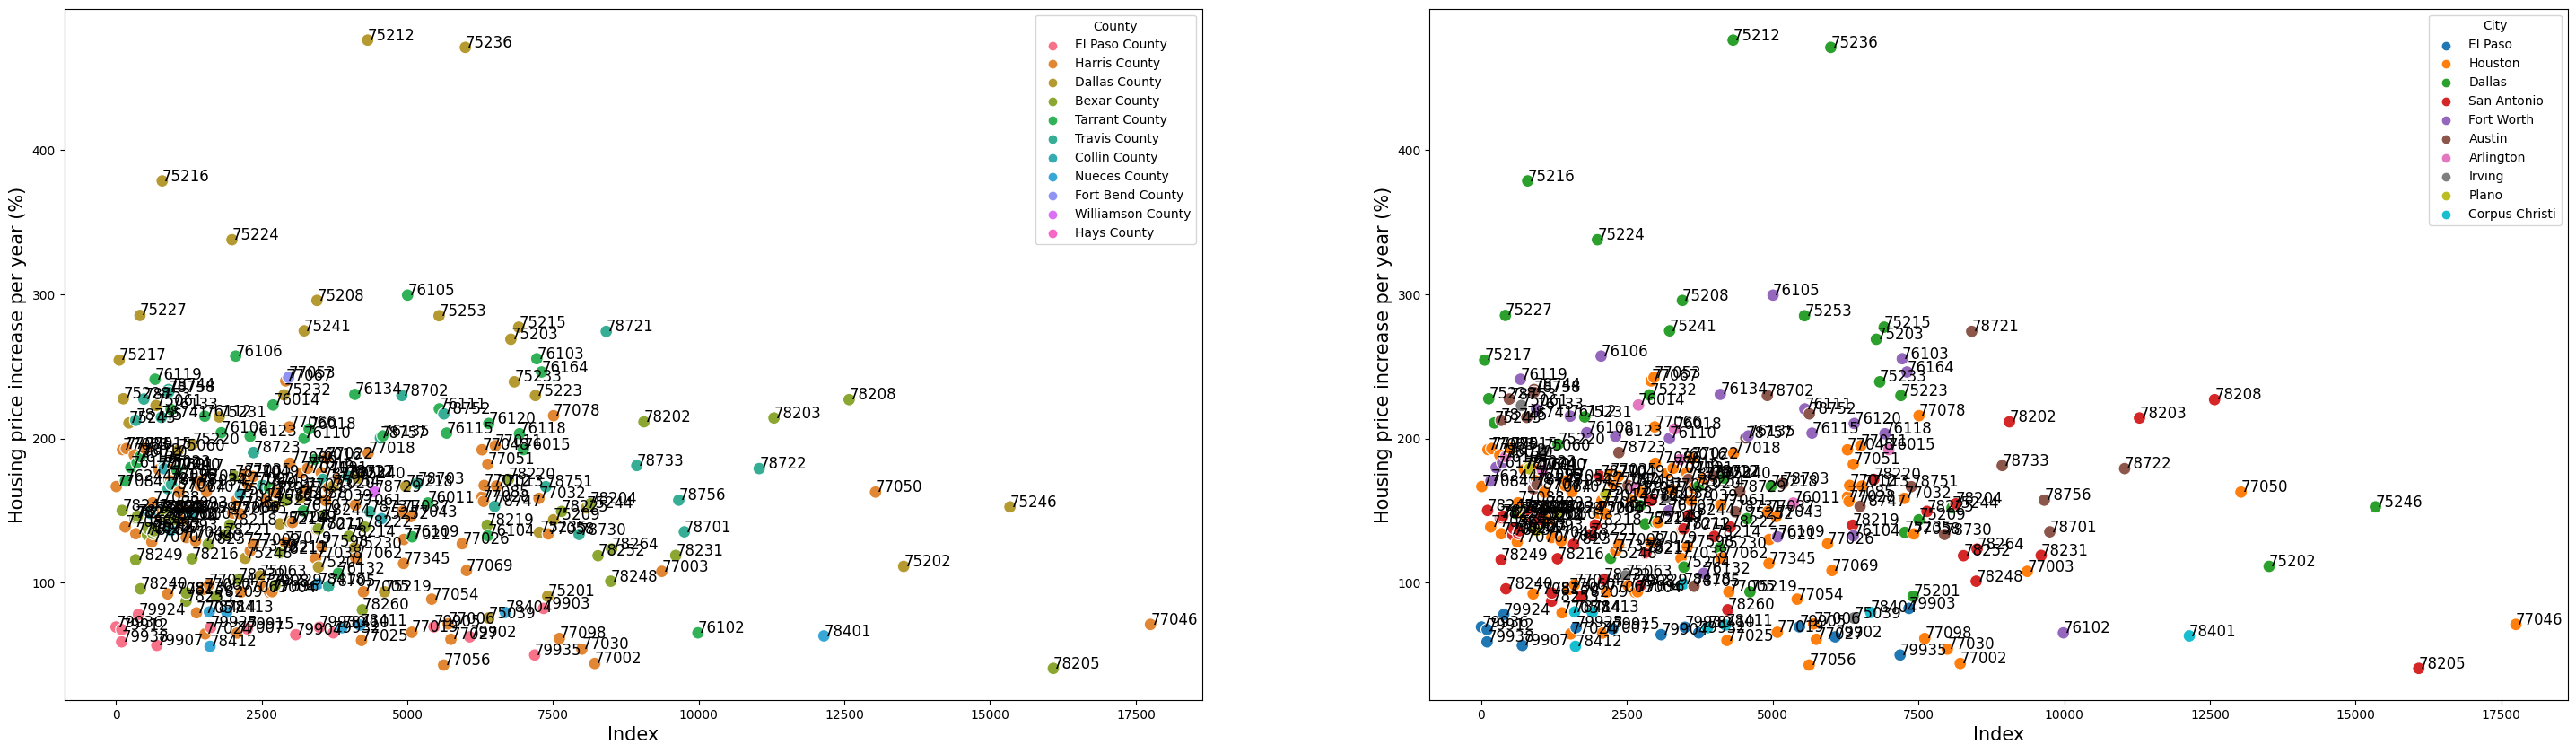

In [31]:
uni_scatterplot(df_zillow,'PriceIncreasePerc','Housing price increase per year (%)')

In [33]:
df_zillow_10yr_roi = return_on_investment(df_zillow, 10)

                count           mean    median            std         sum
City                                                                     
El Paso            14   60998.714286   59183.0    8746.741753    853982.0
Corpus Christi      8   79551.500000   68212.5   29933.770050    636412.0
Houston            92  116329.380435  109493.5   41797.204518  10702303.0
San Antonio        43  118061.488372  111834.0   28168.134261   5076644.0
Arlington           9  144484.777778  148389.0   17389.924646   1300363.0
Fort Worth         25  149105.400000  148505.0   21055.691018   3727635.0
Irving              6  161200.000000  160616.0   12187.990909    967200.0
Dallas             37  192299.432432  173542.0   67512.569167   7115079.0
Plano               6  208029.500000  218179.5   27845.717120   1248177.0
Austin             27  358789.851852  330986.0  125010.047569   9687326.0
                   count           mean    median            std         sum
County                             

In [34]:
df_zillow_10yr_ror = rate_of_return(df_zillow, 10)

                count       mean     median       std          sum
City                                                              
El Paso            14  39.763711  40.376926  2.986374   556.691959
Corpus Christi      8  42.420118  42.821862  4.232476   339.360942
San Antonio        43  56.219566  57.625487  6.936539  2417.441322
Houston            92  56.837959  59.820825  9.158248  5229.092182
Irving              6  58.235066  60.241670  9.638586   349.410395
Plano               6  61.272636  60.832350  2.655238   367.635815
Austin             27  63.876755  63.191604  5.030494  1724.672378
Arlington           9  64.791937  64.974581  2.502409   583.127430
Fort Worth         25  65.025797  67.033748  7.507113  1625.644918
Dallas             37  65.125846  63.322509  9.180987  2409.656298
                   count       mean     median       std          sum
County                                                               
El Paso County        14  39.763711  40.376926  2.986374

### 12. Major Florida cities

In [35]:
path = r'C:\Users\sdas\Github_DS\north_carolina_best_real_estate_locations\Datasets\Zip_zhvi_bdrmcnt_2_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv'
df_zillow = pd.read_csv(path)
df_zillow.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,71959.0,...,185348.0,189190.0,192930.0,196007.0,198450.0,199265.0,199801.0,200478.0,202409.0,203667.0
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,NaN,...,349154.0,358056.0,365657.0,370044.0,370861.0,368537.0,368319.0,369042.0,371358.0,371340.0
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,71722.0,...,139025.0,141675.0,144407.0,147117.0,148500.0,149784.0,150962.0,152527.0,153612.0,154389.0
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,223073.0,...,472787.0,473026.0,473582.0,476574.0,479754.0,480962.0,481936.0,482562.0,482251.0,482909.0
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,230564.0,...,702012.0,705073.0,710696.0,716560.0,721183.0,722750.0,723304.0,727186.0,730187.0,729557.0


In [36]:
df_zillow = filter_data_pipeline(df_zillow,city_col_name="City",state_col_name="State",
                cols=['RegionName','City','State','CountyName','SizeRank'],
                start_date='2012-01',end_date='2022-12',
                cities=['Jacksonville','Miami','Tampa','Orlando','St. Petersburg','Hialeah','Port St. Lucie',
                       'Tallahassee','Cape Coral','Fort Lauderdale'],
                states=['FL'])
df_zillow.head()

,ZipCode,City,State,County,SizeRank,StartPrice,EndPrice
130,33311,Fort Lauderdale,FL,Broward County,133,72181.0,289021.0
147,33012,Hialeah,FL,Miami-Dade County,150,77406.0,232585.0
178,33647,Tampa,FL,Hillsborough County,181,77189.0,238344.0
286,32828,Orlando,FL,Orange County,289,84384.0,310703.0
374,32210,Jacksonville,FL,Duval County,380,60208.0,197823.0


In [37]:
df_zillow = add_price_metrics(df_zillow,10)
df_zillow.head()

,ZipCode,City,State,County,SizeRank,StartPrice,EndPrice,PriceIncrease,PriceIncreasePerc,PriceIncreaseYearly
130,33311,Fort Lauderdale,FL,Broward County,133,72181.0,289021.0,216840.0,300.411466,21684.0
147,33012,Hialeah,FL,Miami-Dade County,150,77406.0,232585.0,155179.0,200.474123,15517.9
178,33647,Tampa,FL,Hillsborough County,181,77189.0,238344.0,161155.0,208.779748,16115.5
286,32828,Orlando,FL,Orange County,289,84384.0,310703.0,226319.0,268.201318,22631.9
374,32210,Jacksonville,FL,Duval County,380,60208.0,197823.0,137615.0,228.565971,13761.5


In [38]:
agg_by_city(df_zillow,'EndPrice')

                      mean    median        std       max       min  \
City                                                                  
Fort Lauderdale  505500.22  529589.0  125590.22  717798.0  289021.0   
Miami            488311.00  495567.0  161612.73  747872.0  271187.0   
Tampa            389335.64  362168.0  161712.67  736992.0  178915.0   
Cape Coral       353958.33  305692.5  116233.36  574502.0  271853.0   
Hialeah          341360.75  337586.0  115040.32  457686.0  232585.0   
Orlando          282177.13  249812.0   95240.80  522706.0  168916.0   
Jacksonville     220449.38  227420.0   61549.76  339994.0  102291.0   
Tallahassee      172896.40  172319.0   47734.55  243342.0  109171.0   

                       sum  count  
City                               
Fort Lauderdale  4549502.0      9  
Miami            9277909.0     19  
Tampa            5450699.0     14  
Cape Coral       2123750.0      6  
Hialeah          1365443.0      4  
Orlando          6490074.0     23  
J

In [39]:
agg_by_county(df_zillow,'EndPrice')

                          mean    median        std       max       min  \
County                                                                    
Broward County       505500.22  529589.0  125590.22  717798.0  289021.0   
Miami-Dade County    462754.43  457686.0  162535.91  747872.0  232585.0   
Hillsborough County  389335.64  362168.0  161712.67  736992.0  178915.0   
Lee County           353958.33  305692.5  116233.36  574502.0  271853.0   
Orange County        282177.13  249812.0   95240.80  522706.0  168916.0   
Duval County         220449.38  227420.0   61549.76  339994.0  102291.0   
Leon County          172896.40  172319.0   47734.55  243342.0  109171.0   

                            sum  count  
County                                  
Broward County        4549502.0      9  
Miami-Dade County    10643352.0     23  
Hillsborough County   5450699.0     14  
Lee County            2123750.0      6  
Orange County         6490074.0     23  
Duval County          6393032.0     2

In [40]:
agg_by_city(df_zillow,'PriceIncreasePerc')

                   mean  median     std     max     min      sum  count
City                                                                   
Tampa            306.60  259.31  103.63  549.49  208.78  4292.38     14
Orlando          258.54  266.26   67.05  394.82  128.97  5946.52     23
Jacksonville     246.14  218.91   73.33  422.86  152.47  7137.94     29
Hialeah          234.34  231.26   32.39  274.37  200.47   937.37      4
Cape Coral       213.65  212.36   36.69  273.17  162.41  1281.88      6
Miami            193.99  180.08   84.33  421.49   74.11  3685.72     19
Fort Lauderdale  172.80  147.36   60.80  300.41  115.01  1555.19      9
Tallahassee       83.33   85.90   23.13  117.92   33.10   749.94      9


In [41]:
agg_by_county(df_zillow,'PriceIncreasePerc')

                       mean  median     std     max     min      sum  count
County                                                                     
Hillsborough County  306.60  259.31  103.63  549.49  208.78  4292.38     14
Orange County        258.54  266.26   67.05  394.82  128.97  5946.52     23
Duval County         246.14  218.91   73.33  422.86  152.47  7137.94     29
Lee County           213.65  212.36   36.69  273.17  162.41  1281.88      6
Miami-Dade County    201.00  192.22   78.78  421.49   74.11  4623.09     23
Broward County       172.80  147.36   60.80  300.41  115.01  1555.19      9
Leon County           83.33   85.90   23.13  117.92   33.10   749.94      9


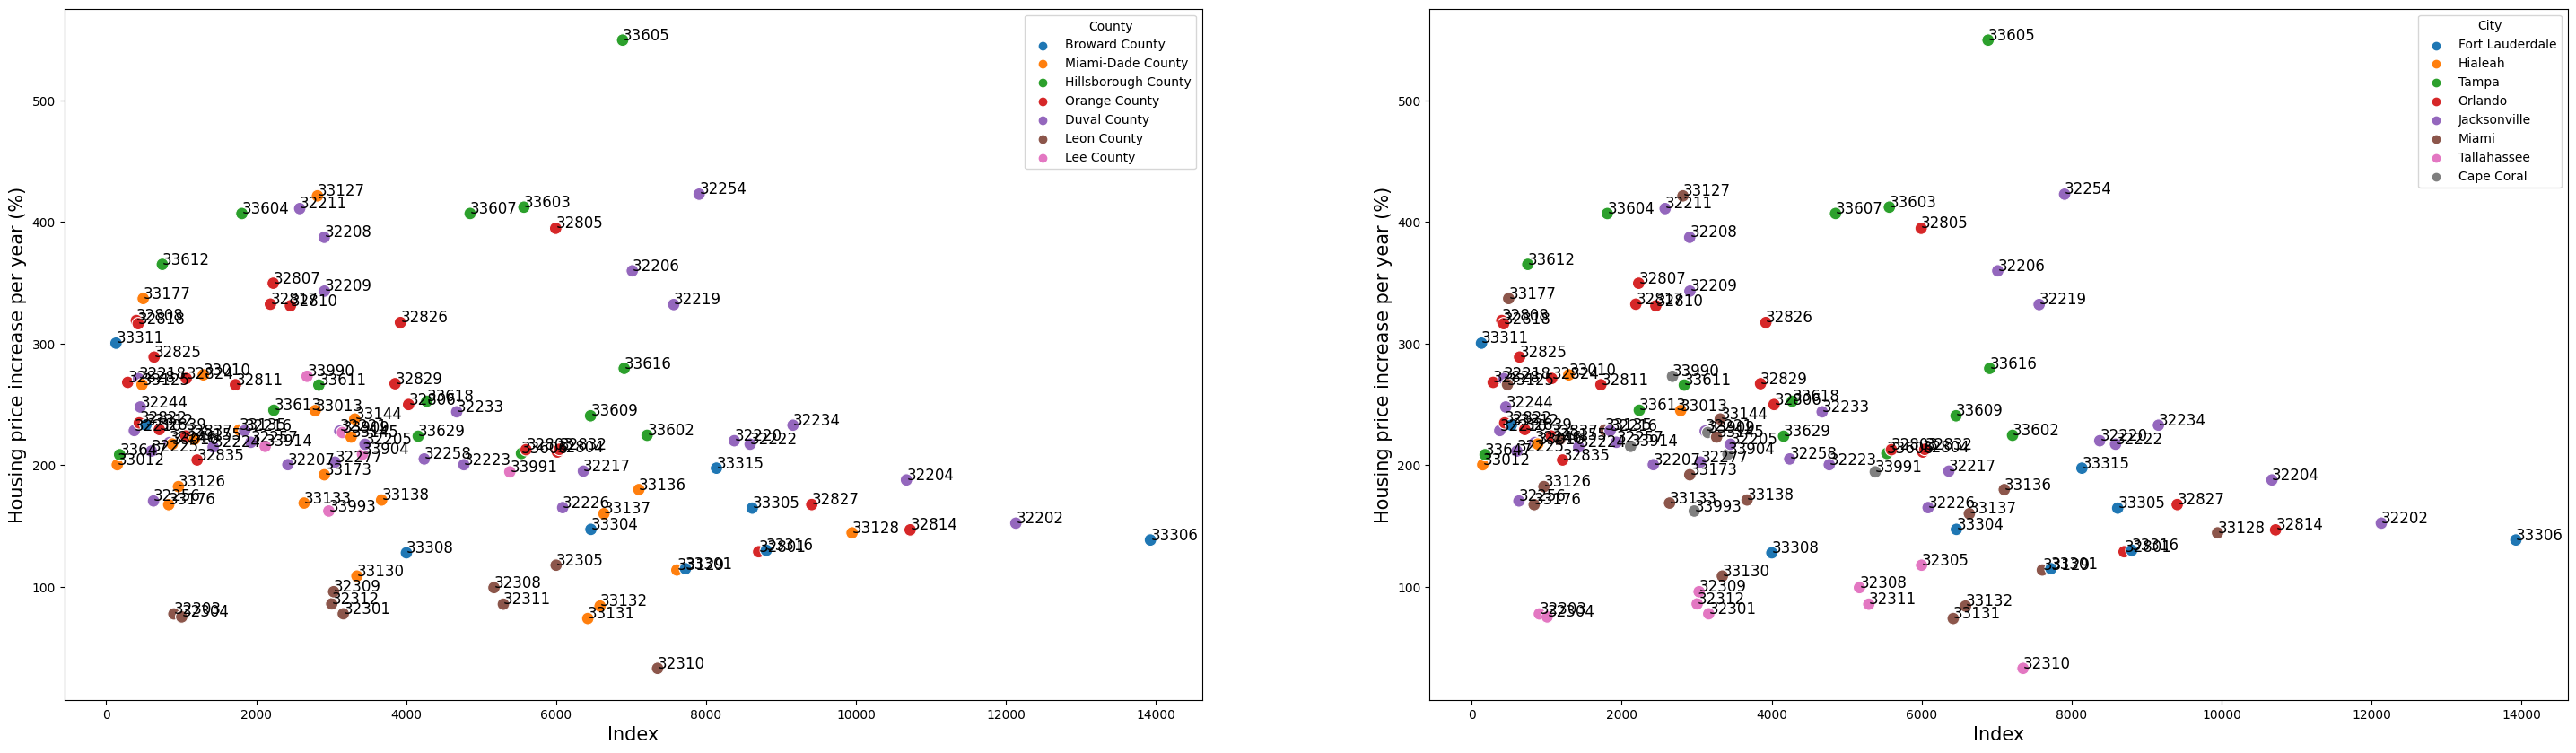

In [42]:
uni_scatterplot(df_zillow,'PriceIncreasePerc','Housing price increase per year (%)')

In [43]:
df_zillow_10yr_roi = return_on_investment(df_zillow, 10)

                 count           mean    median            std        sum
City                                                                     
Tallahassee          9   74976.666667   72321.0   26334.708191   674790.0
Jacksonville        29  152096.931034  152443.0   36298.228327  4410811.0
Orlando             23  196621.347826  186130.0   51736.522589  4522291.0
Cape Coral           6  236563.166667  207799.0   62831.484491  1419379.0
Hialeah              4  240732.500000  241360.0   88857.455529   962930.0
Tampa               14  284793.214286  281059.0  105587.236739  3987105.0
Miami               19  302940.631579  313025.0   88354.888602  5755872.0
Fort Lauderdale      9  306861.000000  302460.0   56182.997519  2761749.0
                     count           mean    median            std        sum
County                                                                       
Leon County              9   74976.666667   72321.0   26334.708191   674790.0
Duval County            29

In [44]:
df_zillow_10yr_ror = rate_of_return(df_zillow, 10)

                 count       mean     median       std          sum
City                                                               
Tallahassee          9  44.548173  46.208560  8.187909   400.933560
Fort Lauderdale      9  61.945568  59.572501  7.159657   557.510114
Miami               19  63.491536  64.296302  9.813797  1206.339184
Cape Coral           6  67.755352  67.981917  3.742163   406.532115
Hialeah              4  69.882088  69.760262  2.874703   279.528354
Jacksonville        29  70.042053  68.643261  5.320278  2031.219537
Orlando             23  71.087410  72.697346  5.868716  1635.010438
Tampa               14  74.105142  72.159285  5.599454  1037.471982
                     count       mean     median       std          sum
County                                                                 
Leon County              9  44.548173  46.208560  8.187909   400.933560
Broward County           9  61.945568  59.572501  7.159657   557.510114
Miami-Dade County       23  64.6

### 13. Major New York cities

In [11]:
path = r'C:\Users\sdas\Github_DS\north_carolina_best_real_estate_locations\Datasets\Zip_zhvi_bdrmcnt_2_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv'
df_zillow = pd.read_csv(path)
df_zillow.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,71959.0,...,185348.0,189190.0,192930.0,196007.0,198450.0,199265.0,199801.0,200478.0,202409.0,203667.0
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,NaN,...,349154.0,358056.0,365657.0,370044.0,370861.0,368537.0,368319.0,369042.0,371358.0,371340.0
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,71722.0,...,139025.0,141675.0,144407.0,147117.0,148500.0,149784.0,150962.0,152527.0,153612.0,154389.0
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,223073.0,...,472787.0,473026.0,473582.0,476574.0,479754.0,480962.0,481936.0,482562.0,482251.0,482909.0
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,230564.0,...,702012.0,705073.0,710696.0,716560.0,721183.0,722750.0,723304.0,727186.0,730187.0,729557.0


In [46]:
df_zillow = filter_data_pipeline(df_zillow,city_col_name="City",state_col_name="State",
                cols=['RegionName','City','State','CountyName','SizeRank'],
                start_date='2012-01',end_date='2022-12',
                cities=['New York','Buffalo','Yonkers','Rochester','Syracuse','Albany','New Rochelle',
                        'Cheektowaga','Mount Vernon','Schenectady'],
                states=['NY'])
df_zillow.head()

,ZipCode,City,State,County,SizeRank,StartPrice,EndPrice
3,11368,New York,NY,Queens County,3,322850.0,482909.0
4,11385,New York,NY,Queens County,4,389338.0,729557.0
11,11236,New York,NY,Kings County,11,367524.0,567209.0
14,11208,New York,NY,Kings County,14,332589.0,741178.0
15,10467,New York,NY,Bronx County,15,139205.0,287065.0


In [47]:
df_zillow = add_price_metrics(df_zillow,10)
df_zillow.head()

,ZipCode,City,State,County,SizeRank,StartPrice,EndPrice,PriceIncrease,PriceIncreasePerc,PriceIncreaseYearly
3,11368,New York,NY,Queens County,3,322850.0,482909.0,160059.0,49.576893,16005.9
4,11385,New York,NY,Queens County,4,389338.0,729557.0,340219.0,87.383970,34021.9
11,11236,New York,NY,Kings County,11,367524.0,567209.0,199685.0,54.332506,19968.5
14,11208,New York,NY,Kings County,14,332589.0,741178.0,408589.0,122.851026,40858.9
15,10467,New York,NY,Bronx County,15,139205.0,287065.0,147860.0,106.217449,14786.0


In [48]:
agg_by_city(df_zillow,'EndPrice')

                   mean    median        std        max       min  \
City                                                                
New York      867055.13  653504.0  541301.59  2902519.0  200468.0   
New Rochelle  710053.00  675766.0   78092.96   799424.0  654969.0   
Yonkers       568474.00  564367.0   23226.02   603459.0  540136.0   
Mount Vernon  526223.00  526223.0   38073.46   553145.0  499301.0   
Albany        206695.38  223050.0   68062.58   303639.0  106333.0   
Buffalo       195190.12  183823.5   90056.72   493596.0   86799.0   
Schenectady   179385.25  195676.0   51635.42   236282.0   69331.0   
Rochester     152424.67  158128.0   48877.90   228394.0   55832.0   
Syracuse      148880.57  139683.5   44968.46   264301.0   97520.0   

                      sum  count  
City                              
New York      144798207.0    167  
New Rochelle    2130159.0      3  
Yonkers         2842370.0      5  
Mount Vernon    1052446.0      2  
Albany          1653563.0     

In [49]:
agg_by_county(df_zillow,'EndPrice')

                          mean     median        std        max       min  \
County                                                                      
New York County     1510408.48  1461285.0  624454.01  2902519.0  563889.0   
Kings County         818707.08   694566.0  302011.76  1546825.0  469803.0   
Queens County        614788.56   622156.0  146046.30   964133.0  334179.0   
Westchester County   602497.50   569505.5   86879.58   799424.0  499301.0   
Richmond County      522781.33   528671.0   41550.18   587391.0  425236.0   
Bronx County         395985.18   360820.0  126070.74   583195.0  200468.0   
Albany County        206695.38   223050.0   68062.58   303639.0  106333.0   
Erie County          195190.12   183823.5   90056.72   493596.0   86799.0   
Schenectady County   179385.25   195676.0   51635.42   236282.0   69331.0   
Monroe County        152424.67   158128.0   48877.90   228394.0   55832.0   
Onondaga County      148880.57   139683.5   44968.46   264301.0   97520.0   

In [50]:
agg_by_city(df_zillow,'PriceIncreasePerc')

                mean  median    std     max    min      sum  count
City                                                              
Buffalo       133.45  132.05  56.83  237.38 -34.21  3202.88     24
Rochester      84.06   81.26  18.19  124.89  36.66  1765.36     21
Syracuse       72.14   71.99   7.40   86.03  60.39   937.80     13
New York       62.93   65.94  29.98  168.78  -5.29  8999.41    143
Schenectady    60.89   56.21  11.41   83.82  53.90   365.33      6
Mount Vernon   60.67   60.67  11.86   69.06  52.29   121.35      2
Yonkers        53.54   54.59   7.21   63.58  43.77   267.70      5
New Rochelle   52.03   59.31  14.18   61.09  35.69   156.09      3
Albany         43.81   47.31  16.53   64.27  11.40   350.48      8


In [51]:
agg_by_county(df_zillow,'PriceIncreasePerc')

                      mean  median    std     max    min      sum  count
County                                                                  
Erie County         133.45  132.05  56.83  237.38 -34.21  3202.88     24
Monroe County        84.06   81.26  18.19  124.89  36.66  1765.36     21
Kings County         78.70   68.57  32.27  168.78  29.30  2833.18     36
Queens County        72.35   71.34  19.00  109.79  24.31  3617.39     50
Onondaga County      72.14   71.99   7.40   86.03  60.39   937.80     13
Richmond County      67.21   68.15   7.14   78.07  51.18   806.51     12
Bronx County         62.18   66.89  27.51  106.22  13.41   621.78     10
Schenectady County   60.89   56.21  11.41   83.82  53.90   365.33      6
Westchester County   54.51   54.85   9.72   69.06  35.69   545.13     10
Albany County        43.81   47.31  16.53   64.27  11.40   350.48      8
New York County      32.02   28.11  23.71   90.69  -5.29  1120.55     35


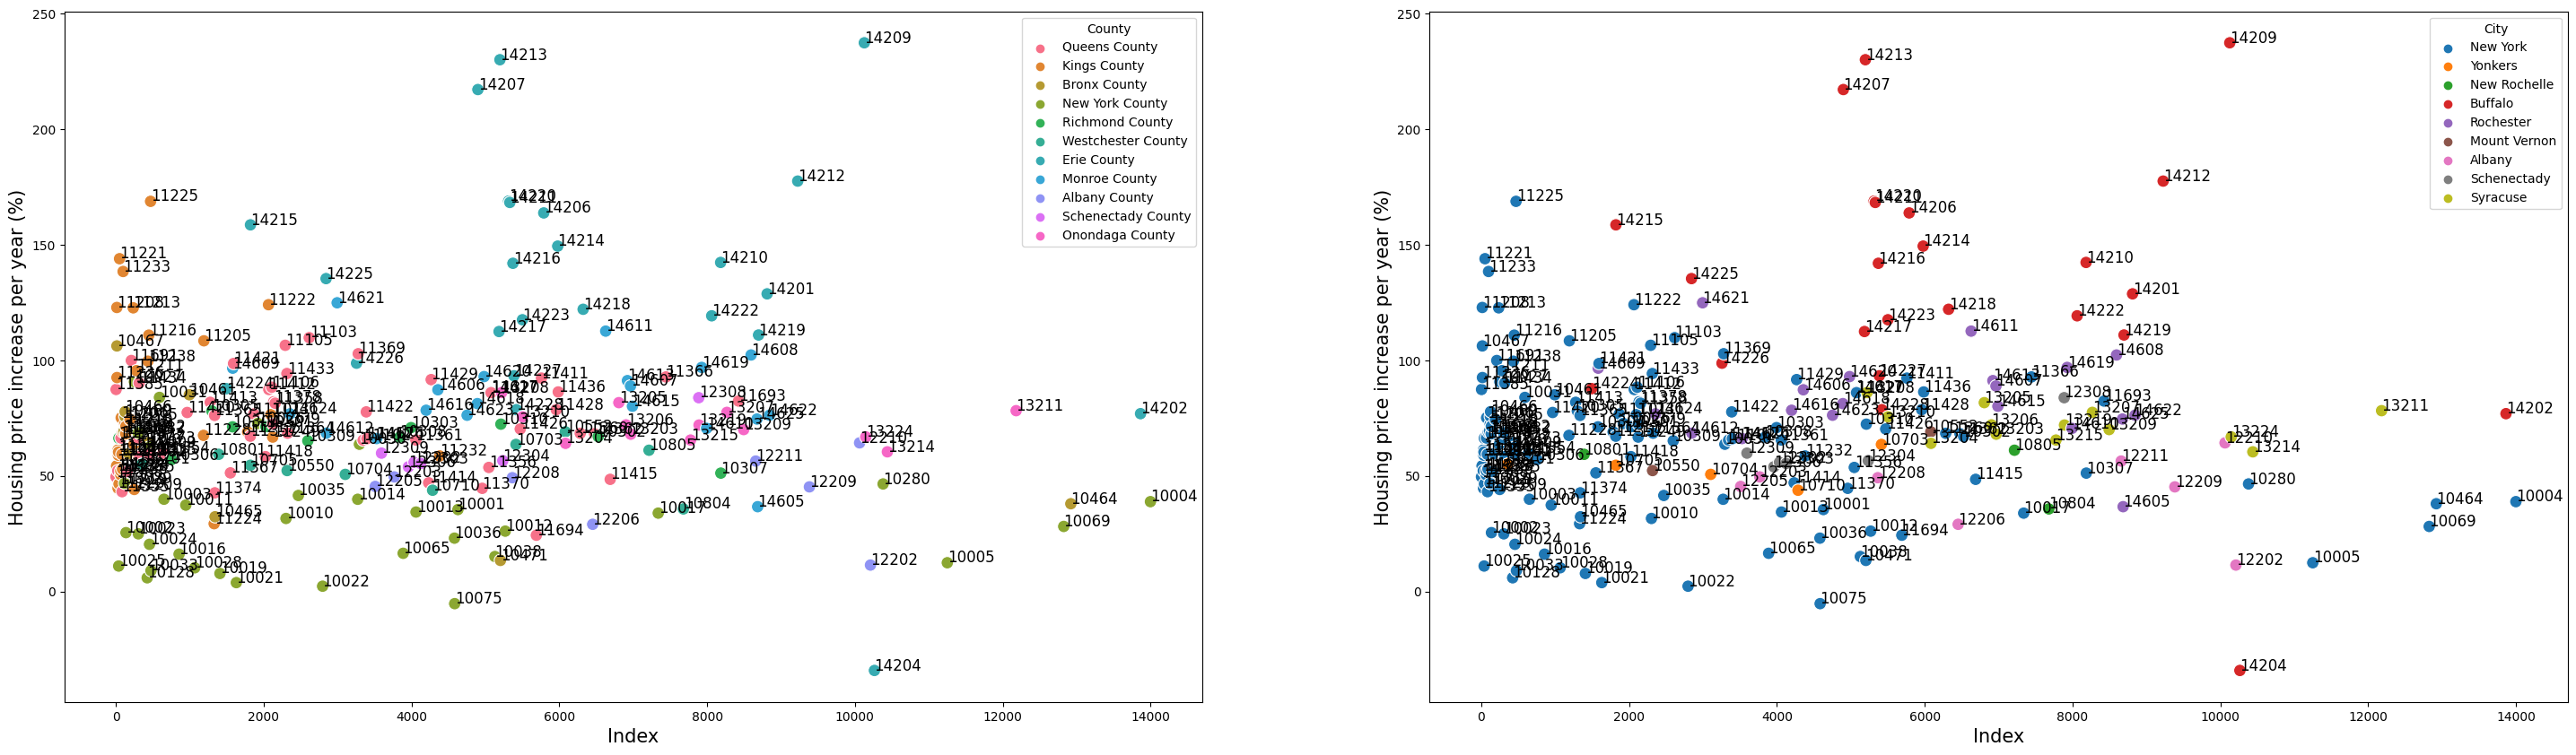

In [52]:
uni_scatterplot(df_zillow,'PriceIncreasePerc','Housing price increase per year (%)')

In [53]:
df_zillow_10yr_roi = return_on_investment(df_zillow, 10)

              count           mean    median            std         sum
City                                                                   
Syracuse         13   58248.000000   57439.0   11835.829608    757224.0
Albany            8   65887.250000   71798.0   33571.102321    527098.0
Rochester        21   68642.380952   71189.0   21373.591024   1441490.0
Schenectady       6   72995.666667   72429.5    8830.954278    437974.0
Buffalo          24  103914.458333   99309.5   54775.805363   2493947.0
Yonkers           5  197008.600000  197662.0    9631.159292    985043.0
Mount Vernon      2  198693.500000  198693.5   38557.825671    397387.0
New Rochelle      3  236789.666667  243834.0   23807.396547    710369.0
New York        143  287824.118881  253098.0  152104.483241  41158849.0
                    count           mean    median            std         sum
County                                                                       
Onondaga County        13   58248.000000   57439.0  

In [54]:
df_zillow_10yr_ror = rate_of_return(df_zillow, 10)

              count       mean     median        std          sum
City                                                             
Albany            8  29.549542  32.103640   9.155748   236.396339
New Rochelle      3  33.817836  37.228327   6.519230   101.453509
Yonkers           5  34.755029  35.311667   3.069626   173.775144
New York        143  36.419832  39.737936  12.527787  5208.036036
Mount Vernon      2  37.591743  37.591743   4.607429    75.183485
Schenectady       6  37.608936  35.982461   3.994966   225.653618
Syracuse         13  41.808878  41.857718   2.480875   543.515415
Rochester        21  45.135669  44.830862   5.789030   947.849043
Buffalo          24  52.569412  56.897260  23.495725  1261.665890
                    count       mean     median        std          sum
County                                                                 
New York County        35  22.016651  21.944439  13.067198   770.582798
Albany County           8  29.549542  32.103640   9.155748

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import requests
import json
from bs4 import BeautifulSoup
import geopy
from geopy.geocoders import Nominatim
from math_functions import *
from wrangling_functions import *
from plotting_functions import *
from data_extraction_functions import *

path = r'C:\Users\sdas\Github_DS\north_carolina_best_real_estate_locations\Datasets\Zip_zhvi_bdrmcnt_2_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv'
df_zillow = pd.read_csv(path)

df_zillow = filter_data_pipeline(df_zillow,city_col_name="City",state_col_name="State",
                cols=['RegionName','City','State','CountyName','SizeRank'],
                start_date='2012-01',end_date='2022-12',
                cities=[],
                states=['NY'])
df_zillow.head()

#df_zillow[['City','EndPrice']].groupby('City').agg(['count','mean','median','std','sum'])['EndPrice'].sort_values('mean',ascending=False)

,ZipCode,City,State,County,SizeRank,StartPrice,EndPrice
3,11368,New York,NY,Queens County,3,322850.0,482909.0
4,11385,New York,NY,Queens County,4,389338.0,729557.0
11,11236,New York,NY,Kings County,11,367524.0,567209.0
14,11208,New York,NY,Kings County,14,332589.0,741178.0
15,10467,New York,NY,Bronx County,15,139205.0,287065.0


In [19]:
df_zillow[df_zillow["City"].isin(['Albany','Rochester','Buffalo'])]['City'].unique()

array(['Buffalo', 'Rochester', 'Albany'], dtype=object)

In [12]:
df_zillow["City"]=='Albany'

3        True
4        True
11       True
14       True
15       True
         ... 
18859    True
18864    True
18866    True
18868    True
18887    True
Name: City, Length: 1230, dtype: bool

In [25]:
path = r'C:\Users\sdas\Github_DS\north_carolina_best_real_estate_locations\Datasets\Zip_zhvi_bdrmcnt_2_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv'

sorted(pd.Series(df_zillow['City'].unique()).dropna())

['Accord',
 'Adams',
 'Adams Center',
 'Addison',
 'Adirondack',
 'Afton',
 'Akron',
 'Albany',
 'Albion',
 'Alden',
 'Alexander',
 'Alexandria Bay',
 'Alfred Station',
 'Allegany',
 'Almond',
 'Alpine',
 'Altamont',
 'Altmar',
 'Altona',
 'Amawalk',
 'Amenia',
 'Amityville',
 'Amsterdam',
 'Ancram',
 'Ancramdale',
 'Andes',
 'Andover',
 'Angelica',
 'Angola',
 'Apalachin',
 'Arcade',
 'Argyle',
 'Arkport',
 'Arkville',
 'Ashville',
 'Athens',
 'Athol',
 'Attica',
 'Au Sable Forks',
 'Auburn',
 'Aurora',
 'Averill Park',
 'Avoca',
 'Avon',
 'Babylon',
 'Bainbridge',
 'Baldwin',
 'Baldwinsville',
 'Ballston Lake',
 'Ballston Spa',
 'Barker',
 'Barneveld',
 'Barryville',
 'Barton',
 'Batavia',
 'Bath',
 'Bay Shore',
 'Bayville',
 'Beacon',
 'Bearsville',
 'Beaver Dams',
 'Bedford Hills',
 'Belfast',
 'Belmont',
 'Bemus Point',
 'Bergen',
 'Berkshire',
 'Berne',
 'Bernhards Bay',
 'Bethel',
 'Bethpage',
 'Big Flats',
 'Big Indian',
 'Binghamton',
 'Black River',
 'Blauvelt',
 'Bliss',
 'B

In [2]:
x = agg_by_city(df_zillow,'EndPrice')

               count       mean     median  std        max        min  \
City                                                                    
Bridgehampton      1  2449313.0  2449313.0  NaN  2449313.0  2449313.0   
Water Mill         1  2277084.0  2277084.0  NaN  2277084.0  2277084.0   
Montauk            1  1873030.0  1873030.0  NaN  1873030.0  1873030.0   
Sag Harbor         1  1598714.0  1598714.0  NaN  1598714.0  1598714.0   
East Hampton       1  1510822.0  1510822.0  NaN  1510822.0  1510822.0   
...              ...        ...        ...  ...        ...        ...   
Wellsville         1    75381.0    75381.0  NaN    75381.0    75381.0   
Massena            1    75310.0    75310.0  NaN    75310.0    75310.0   
Canaseraga         1    75001.0    75001.0  NaN    75001.0    75001.0   
Bolivar            1    62344.0    62344.0  NaN    62344.0    62344.0   
Star Lake          1    50850.0    50850.0  NaN    50850.0    50850.0   

                     sum  
City                   

In [6]:
x['mean'].index

Index(['Bridgehampton', 'Water Mill', 'Montauk', 'Sag Harbor', 'East Hampton',
       'Remsenburg', 'Manhasset', 'Rye', 'Westhampton Beach', 'Southampton',
       ...
       'Friendship', 'Saint Regis Falls', 'Norfolk', 'Limestone', 'Ogdensburg',
       'Wellsville', 'Massena', 'Canaseraga', 'Bolivar', 'Star Lake'],
      dtype='object', name='City', length=958)

In [7]:
'Foot'.lower()

'foot'